<a href="https://colab.research.google.com/github/farhanarrafi/proto-language-reconstruction-using-bengali-dialects/blob/main/colab/Proto_language_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [20]:
import os.path
import json
import pandas as pd
from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()


api_token = {"username":"farhanarrafi","key":"4f070f664abbd64c4eed43162a528d02"}


# https://stackoverflow.com/a/57401752/3148856
if not os.path.isdir('/root/.kaggle'):
  ! mkdir ~/.kaggle
  ! touch ~/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)
  !chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets list

### Download Dataset

In [ ]:
if not os.path.isfile('BanglaDial.csv'):
    ! kaggle datasets download -d farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
    ! unzip bangladial-a-dataset-for-bengali-dialect-analysis.zip
    ! rm -rf bangladial-a-dataset-for-bengali-dialect-analysis.zip

Dataset URL: https://www.kaggle.com/datasets/farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
License(s): CC-BY-SA-4.0
Archive:  bangladial-a-dataset-for-bengali-dialect-analysis.zip
  inflating: BanglaDial.csv          
  inflating: BanglaDial.xlsx         
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis. - Sheet1.csv  
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis..xlsx  


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


bangladial_dataset = pd.read_csv('BanglaDial.csv')

In [ ]:
bangladial_dataset.head()

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla


In [ ]:
bangladial_languages = bangladial_dataset['Language'].unique()

In [ ]:
bangladial_dataset.shape

(63303, 2)

In [ ]:
# bangladial_dataset['row'] = bangladial_dataset.groupby('Language').cumcount()

# # Pivot the table
# bangladial = bangladial_dataset.pivot(index='row', columns='Language', values='Sentence')

# # Optional: reset index if you want a clean DataFrame
# bangladial = bangladial.reset_index(drop=True)


In [ ]:
bangladial = bangladial_dataset
bangladial.head(10)

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla
5,মেয়েটি লাল রঙয়ের শাড়ি পরে আমার সাথে দেখা করতে ...,Standard_Bangla
6,ছেলেটি সিলেট থেকে ঢাকায় এসেছে,Standard_Bangla
7,মেয়েটি সিলেট থেকে আসা এই ছেলেটিকে অনেক ভালবাসে,Standard_Bangla
8,ছেলেটি মেয়েটাকে এখনো ভালবাসার চোখে দেখেনি,Standard_Bangla
9,মেয়েটি তাঁর সব স্বপ্নের মধ্যে ছেলেটাকে কল্পনা করে,Standard_Bangla


In [ ]:
if not os.path.isfile('Vashantor/Final/Classification.csv'):
    ! kaggle datasets download -d raiyanzannat/vashantor
    ! unzip vashantor.zip
    ! rm -rf vashantor.zip

Dataset URL: https://www.kaggle.com/datasets/raiyanzannat/vashantor
License(s): apache-2.0
Archive:  vashantor.zip
  inflating: Vashantor/Combined/Barishal_Combined_Translation.csv  
  inflating: Vashantor/Combined/Chittagong_Combined_Translation.csv  
  inflating: Vashantor/Combined/Mymensingh_Combined_Translation.csv  
  inflating: Vashantor/Combined/Noakhali_Combined_Translation.csv  
  inflating: Vashantor/Combined/Sylhet_Combined_Translation.csv  
  inflating: Vashantor/Final/Barishal.csv  
  inflating: Vashantor/Final/Chittagong.csv  
  inflating: Vashantor/Final/Classification.csv  
  inflating: Vashantor/Final/Mymensingh.csv  
  inflating: Vashantor/Final/Noakhali.csv  
  inflating: Vashantor/Final/Sylhet.csv  


In [ ]:
vashantor_barishal = pd.read_csv('Vashantor/Final/Barishal.csv')
vashantor_chittagong = pd.read_csv('Vashantor/Final/Chittagong.csv')
vashantor_noakhali = pd.read_csv('Vashantor/Final/Noakhali.csv')
vashantor_mymensingh = pd.read_csv('Vashantor/Final/Mymensingh.csv')
vashantor_sylhet = pd.read_csv('Vashantor/Final/Sylhet.csv')

In [ ]:
vashantor_barishal.columns = vashantor_barishal.columns.str.strip()
vashantor_chittagong.columns = vashantor_chittagong.columns.str.strip()
vashantor_noakhali.columns = vashantor_noakhali.columns.str.strip()
vashantor_mymensingh.columns = vashantor_mymensingh.columns.str.strip()
vashantor_sylhet.columns = vashantor_sylhet.columns.str.strip()

In [ ]:
vashantor_barishal = vashantor_barishal.dropna()
vashantor_chittagong = vashantor_chittagong.dropna()
vashantor_noakhali = vashantor_noakhali.dropna()
vashantor_mymensingh = vashantor_mymensingh.dropna()
vashantor_sylhet = vashantor_sylhet.dropna()

In [ ]:
"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
vashantor_barishal['combined'] = vashantor_barishal['region_name'] + ' ' + vashantor_barishal['regional_text']
vashantor_chittagong['combined'] = vashantor_chittagong['region_name'] + ' ' + vashantor_chittagong['regional_text']
vashantor_noakhali['combined'] = vashantor_noakhali['region_name'] + ' ' + vashantor_noakhali['regional_text']
vashantor_mymensingh['combined'] = vashantor_mymensingh['region_name'] + ' ' + vashantor_mymensingh['regional_text']
vashantor_sylhet['combined'] = vashantor_sylhet['region_name'] + ' ' + vashantor_sylhet['regional_text']

In [ ]:
vashantor_chittagong.head()

,regional_text,bangla_speech,region_name,combined
0,বাংলাদেশত ৬৪ ইয়ান জেলা,বাংলাদেশে ৬৪ টা জেলা,Chittagong,Chittagong বাংলাদেশত ৬৪ ইয়ান জেলা
1,আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম,আমরা সবাই গতকাল বাহিরে গিয়েছিলাম,Chittagong,Chittagong আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম
2,তোইয়ার হতা বলার ধরণ বহুত সুন্দর,তোমার কথা বলার ধরন অনেক সুন্দর,Chittagong,Chittagong তোইয়ার হতা বলার ধরণ বহুত সুন্দর
3,বরিশালর মানুষ হইল্লে অয় দে?,বরিশালের মানুষ কেমন হয়?,Chittagong,Chittagong বরিশালর মানুষ হইল্লে অয় দে?
4,খুলনা জেলা কি বহুত সুন্দর নাকি?,খুলনা জেলা কি অনেক সুন্দর?,Chittagong,Chittagong খুলনা জেলা কি বহুত সুন্দর নাকি?


In [ ]:
vashantor_barishal['combined'].str.len().max()

123

In [ ]:
# https://huggingface.co/teamapocalypseml/regben2ipa-byt5small
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("abdullaharean/regipa_bangla")
model = AutoModelForSeq2SeqLM.from_pretrained("abdullaharean/regipa_bangla")

In [ ]:
#text = "<district> bengali_text_here"
text = vashantor_barishal['combined'][2]
inputs = tokenizer(text, return_tensors='pt')
output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
print(tokenizer.decode(output_ids[0], skip_special_tokens=False))

<pad>bɐɾɔhɐl  t̪umɪ kɪ moɾe e͡ɪ̯ kɐmdɐ ko͡ɪ̯ɾɾɐ d̪et̪e pɐɾbɐ?</s>


In [ ]:
outputs = []

"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
model = model.to(device)

def translate_text(text):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



In [ ]:
vashantor_barishal['ipa_output'] = vashantor_barishal['combined'].astype(str).apply(translate_text)

In [ ]:
vashantor_barishal.to_csv('vashantor_barishal_ipa.csv', index=False)

In [ ]:
vashantor_chittagong['ipa_output'] = vashantor_chittagong['combined'].astype(str).progress_apply(translate_text)

100%|██████████| 2499/2499 [30:11<00:00,  1.38it/s]


In [ ]:
vashantor_chittagong.to_csv('vashantor_chittagong_ipa.csv', index=False)

In [ ]:
vashantor_noakhali['ipa_output'] = vashantor_noakhali['combined'].astype(str).progress_apply(translate_text)
vashantor_noakhali.to_csv('vashantor_noakhali_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:26<00:00,  1.37it/s]


In [ ]:
vashantor_mymensingh['ipa_output'] = vashantor_mymensingh['combined'].astype(str).progress_apply(translate_text)
vashantor_mymensingh.to_csv('vashantor_mymensingh_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:41<00:00,  1.36it/s]


In [ ]:
vashantor_sylhet['ipa_output'] = vashantor_sylhet['combined'].astype(str).progress_apply(translate_text)
vashantor_sylhet.to_csv('vashantor_sylhet_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:30<00:00,  1.36it/s]


In [ ]:
vashantor_barishal = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_chittagong = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_noakhali = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_mymensingh = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_sylhet = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')

In [ ]:
#import epitran

# # Apply the transliteration function to the 'text' column
# df['bangla_speech_ipa'] = df['bangla_speech'].progress_apply(lambda x: epi_beng.transliterate(str(x)))

# df.to_csv('vashantor_sylhet_ipa_with_bangla_ipa.csv', index=False)

In [2]:
bangla_w_pie_root = pd.read_csv('bangla_with_pie_roots.csv')
bangla_without_pie_root = pd.read_csv('bangla_with_no_pie_root_matches.csv')

In [8]:
# Construct input strings from dialectal IPA
def generate_input(row):
    return (
        f"[standard] {row['bangla_speech_ipa']} "
        f"[barishal] {row['barishal_ipa']} "
        f"[sylhet] {row['sylhet_ipa']} "
        f"[mymensingh] {row['mymensingh_ipa']} "
        f"[noakhali] {row['noakhali_ipa']} "
        f"[chittagong] {row['chittagong_ipa']}"
    )

bangla_w_pie_root["input_text"] = bangla_w_pie_root.apply(generate_input, axis=1)
bangla_w_pie_root["target_text"] = bangla_w_pie_root["PIE_root"]

In [4]:
bangla_w_pie_root.head()

,bangla_speech_word,bangla_speech_ipa,barishal_word,barishal_ipa,sylhet_word,sylhet_ipa,mymensingh_word,mymensingh_ipa,noakhali_word,noakhali_ipa,chittagong_word,chittagong_ipa,english_translation,PIE_root,PIE_gloss,input_text,target_text
0,অনলাইনে,on̪l̪ain̪e,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনো,ɔnɔlɐ͡ɪ̯no,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনত,ɔnɔlɐ͡ɪ̯nɔt̪o,Online,"e-neu̯en, neu̯n̥, enu̯n̥",nine,[standard] on̪l̪ain̪e [barishal] ɔnɔlɐ͡ɪ̯ne [s...,"e-neu̯en, neu̯n̥, enu̯n̥"
1,অন্ধকার,on̪d̪̤ɔkar,আন্ধার,ɐnd̪ʱɐɾ,আইন্দার,ɐ͡ɪ̯nd̪ɐɾ,অন্ধকার,ɔnd̪ʱokɐɾ,আন্ধকার,ɐnd̪ʱokɐɾ,অন্ধকার,ɔnd̪ʱokɐɾ,Dark,ku̯sep-,dark,[standard] on̪d̪̤ɔkar [barishal] ɐnd̪ʱɐɾ [sylh...,ku̯sep-
2,অন্ধকার,on̪d̪̤ɔkarɔ,আন্ধার,ɐnd̪ʱɐɾ,ভিতরটা,bʱɪt̪ɔɾtɐ,অন্ধকার,ɔnd̪ʱokɐɾ,ভিতরকান,bʱɪt̪ɔɾkɐn,বাড়ির,bɐɽɪɾ,Dark,ku̯sep-,dark,[standard] on̪d̪̤ɔkarɔ [barishal] ɐnd̪ʱɐɾ [syl...,ku̯sep-
3,অন্যতম,on̪d͡zɔt̪ɔmɔ,অন্যতম,ɔnnot̪ɔmo,হফরি,hofoɾɪ,অন্যতম,ɔnnot̪ɔmo,অন্যতম,ɔnnot̪ɔmo,অন্যতম,ɔnnot̪ɔmo,One,ast(h)-,bone,[standard] on̪d͡zɔt̪ɔmɔ [barishal] ɔnnot̪ɔmo [...,ast(h)-
4,অন্যদের,on̪d͡zɔd̪erɔ,অন্যগো,ɔnnogo,বুঝিয়া,buɟʱɪʲɐ,অন্যরারে,ɔnnoɾɐɾe,অন্যগো,ɔnnogo,আন্যদের,ɐnnod̪eɾ,Others,mātér-,mother,[standard] on̪d͡zɔd̪erɔ [barishal] ɔnnogo [syl...,mātér-


In [9]:
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(bangla_w_pie_root[["input_text", "target_text"]])

In [24]:
# Tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
model = T5ForConditionalGeneration.from_pretrained("google/mt5-small").to(device)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [25]:
# Tokenization functions
def tokenize(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=128)
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=32)
    inputs["labels"] = targets["input_ids"]
    return inputs

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

In [26]:
# Split into train/test (90/10)
split = dataset.train_test_split(test_size=0.1, seed=11)
train_dataset = split["train"]
eval_dataset = split["test"]

In [27]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="t5-pie",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    save_total_limit=2,
    logging_dir="logs",
    report_to="none",  # turn off W&B
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [28]:
train_result = trainer.train()

Step,Training Loss
102,39.294200
204,26.570800
306,19.740800
408,15.638800
510,13.302300
612,11.716900
714,10.209700
816,9.379600
918,8.840200
1020,8.423700


In [32]:
def predict_proto(word_row):
    input_str = generate_input(word_row)
    inputs = tokenizer(input_str, return_tensors="pt", truncation=True, padding=True)
    output_ids = model.generate(**inputs, max_length=32).to(device)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

sample = bangla_w_pie_root.iloc[0]
print("Predicted PIE root:", predict_proto(sample))
print("Gold PIE root:", sample["PIE_root"])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [29]:
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

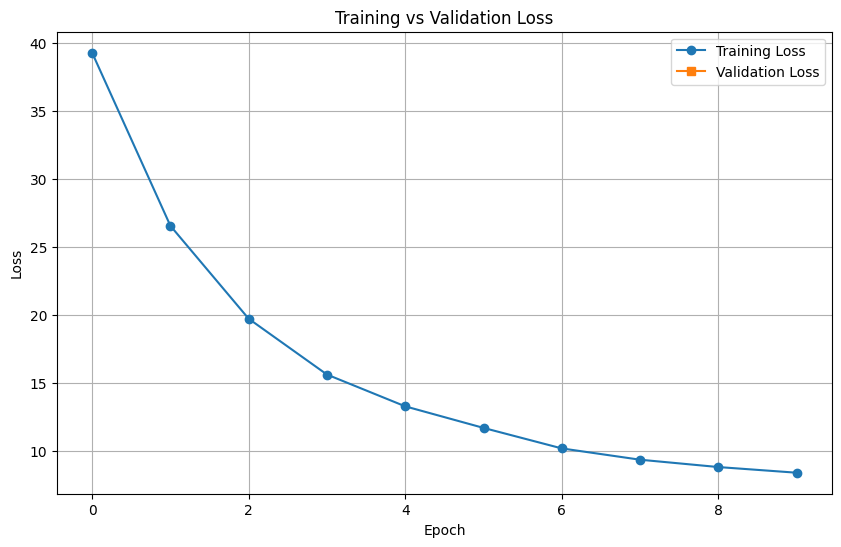

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(eval_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def get_predictions(dataset):
    predictions = []
    references = []
    for row in dataset:
        input_str = row["input_text"]
        inputs = tokenizer(input_str, return_tensors="pt", truncation=True)
        output_ids = model.generate(**inputs, max_length=32)
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append(row["target_text"])
    return predictions, references

preds, refs = get_predictions(eval_dataset)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# Accuracy
exact_matches = [p == r for p, r in zip(preds, refs)]
acc = np.mean(exact_matches)
print(f"Exact Match Accuracy: {acc:.2f}")

In [ ]:
from collections import Counter

root_counts = Counter(df["PIE_root"])
most_common = root_counts.most_common(20)

labels, values = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.barh(labels, values, color='purple')
plt.gca().invert_yaxis()
plt.title("Top 20 Most Frequent PIE Roots")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Focus only on top N most frequent roots
top_roots = [r for r, c in most_common[:10]]
filtered_preds = [p if p in top_roots else "other" for p in preds]
filtered_refs = [r if r in top_roots else "other" for r in refs]

cm = confusion_matrix(filtered_refs, filtered_preds, labels=top_roots + ["other"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_roots + ["other"])
disp.plot(xticks_rotation=45, cmap="Purples")
plt.title("Confusion Matrix of PIE Root Predictions")
plt.show()